<a href="https://colab.research.google.com/github/boneeyah/QTW/blob/main/Case%20Study%201/Case_Study_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
!pip install scikit-learn-intelex

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.9/13.9 MB 55.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.2/69.2 MB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 91.8 MB/s eta 0:00:00


In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from tabulate import tabulate
from sklearn.linear_model import ElasticNet
from sklearn.datasets import make_regression
from sklearn.model_selection import GridSearchCV
from numpy import arange
from sklearnex import patch_sklearn

In [15]:
df = pd.read_csv('https://raw.githubusercontent.com/KendallScott/QTW/main/Case%20Study%201/train.csv') 

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21263 entries, 0 to 21262
Data columns (total 82 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   number_of_elements               21263 non-null  int64  
 1   mean_atomic_mass                 21263 non-null  float64
 2   wtd_mean_atomic_mass             21263 non-null  float64
 3   gmean_atomic_mass                21263 non-null  float64
 4   wtd_gmean_atomic_mass            21263 non-null  float64
 5   entropy_atomic_mass              21263 non-null  float64
 6   wtd_entropy_atomic_mass          21263 non-null  float64
 7   range_atomic_mass                21263 non-null  float64
 8   wtd_range_atomic_mass            21263 non-null  float64
 9   std_atomic_mass                  21263 non-null  float64
 10  wtd_std_atomic_mass              21263 non-null  float64
 11  mean_fie                         21263 non-null  float64
 12  wtd_mean_fie      

In [17]:
unique = pd.read_csv('https://raw.githubusercontent.com/KendallScott/QTW/main/Case%20Study%201/unique_m.csv') 
unique = unique.loc[:, unique.columns != 'critical_temp']
unique = unique.loc[:, unique.columns != 'material']

df=df.join(unique)

In [18]:
#dropping correlated values reference: https://www.projectpro.io/recipes/drop-out-highly-correlated-features-in-python
corr_matrix = df.corr().abs()
corr_matrix

upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# find features with correlation greater than 0.95

to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

# drop highly correlated features

df.drop(to_drop, axis=1, inplace=True)

<ipython-input-18-7c1233e99907>:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))


In [ ]:
# Make target and predictive datasets
y = df[['critical_temp']]
X = df.loc[:, df.columns != 'critical_temp']

In [ ]:
Scaler = StandardScaler()
X_Scaled= Scaler.fit_transform(X)
X_Scaled = pd.DataFrame(X_Scaled, columns = X.columns)
y = pd.DataFrame(y)

In [ ]:
# define grid
grid = dict()
grid['alpha'] = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.0, 1.0, 10.0, 100.0]
grid['l1_ratio'] = arange(0, 1, 0.01)
# define search
search = GridSearchCV(regr, grid, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)

# perform the search
results = search.fit(X_Scaled, y)
# summarize
print('MAE: %.3f' % results.best_score_)
print('Config: %s' % results.best_params_)

MAE: -12.669
Config: {'alpha': 0.001, 'l1_ratio': 0.0}


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.012e+06, tolerance: 2.495e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


Results from the gridsearch CV showed Ridge was selected for regularization.

In [ ]:
regr = ElasticNet(random_state=0, alpha=.001, l1_ratio= 0.0)

i=0

# Create a 10-fold cross-validation 
cv = KFold(n_splits = 10, 
           shuffle = True, 
           random_state = 42)

MAE = []

#i=0
for train, test in cv.split(X_Scaled, y):
    X_train, X_test = X_Scaled.iloc[train], X_Scaled.iloc[test]
    y_train, y_test = y.iloc[train], y.iloc[test]

    X_train, y_train = make_regression(n_features=2, random_state=0)
    
    regr.fit(X_Scaled, y)

    # Predict 
    y_pred_lin_reg = regr.predict(X_test)
  
    # Calculate  mean squared error
    lin_MAE_reg= metrics.mean_absolute_error(y_test, y_pred_lin_reg)

    i=i+1
    # Append to the list
    MAE.append(lin_MAE_reg)

    # Print the scores
    print(tabulate([[i, lin_MAE_reg, ]], 
               headers=['MAE']))

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.137e+06, tolerance: 2.495e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


        MAE
--  -------
 1  12.6582


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.137e+06, tolerance: 2.495e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


        MAE
--  -------
 2  12.3333


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.137e+06, tolerance: 2.495e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


        MAE
--  -------
 3  13.3224


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.137e+06, tolerance: 2.495e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


        MAE
--  -------
 4  12.6584


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.137e+06, tolerance: 2.495e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


        MAE
--  -------
 5  12.7645


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.137e+06, tolerance: 2.495e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


        MAE
--  -------
 6  12.4247


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.137e+06, tolerance: 2.495e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


        MAE
--  -------
 7  13.1939


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.137e+06, tolerance: 2.495e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


        MAE
--  -------
 8  12.6185


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.137e+06, tolerance: 2.495e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


        MAE
--  -------
 9  12.6143
       MAE
--  ------
10  12.929


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.137e+06, tolerance: 2.495e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


In [ ]:
regr.n_features_in_

144

In [ ]:
regr.feature_names_in_

array(['number_of_elements', 'mean_atomic_mass', 'wtd_mean_atomic_mass',
       'gmean_atomic_mass', 'entropy_atomic_mass',
       'wtd_entropy_atomic_mass', 'range_atomic_mass',
       'wtd_range_atomic_mass', 'wtd_std_atomic_mass', 'mean_fie',
       'wtd_mean_fie', 'wtd_entropy_fie', 'range_fie', 'wtd_range_fie',
       'wtd_std_fie', 'mean_atomic_radius', 'wtd_mean_atomic_radius',
       'gmean_atomic_radius', 'range_atomic_radius',
       'wtd_range_atomic_radius', 'mean_Density', 'wtd_mean_Density',
       'gmean_Density', 'entropy_Density', 'wtd_entropy_Density',
       'range_Density', 'wtd_range_Density', 'wtd_std_Density',
       'mean_ElectronAffinity', 'wtd_mean_ElectronAffinity',
       'gmean_ElectronAffinity', 'wtd_gmean_ElectronAffinity',
       'entropy_ElectronAffinity', 'wtd_entropy_ElectronAffinity',
       'range_ElectronAffinity', 'wtd_range_ElectronAffinity',
       'wtd_std_ElectronAffinity', 'mean_FusionHeat',
       'wtd_mean_FusionHeat', 'gmean_FusionHeat', '

In [ ]:
regr.coef_

array([ 1.44707521e+00,  6.23795971e+00, -1.41428401e+01,  4.34478483e+00,
       -4.60323371e+00,  3.02240656e+00,  8.20563932e+00,  2.88658246e+00,
       -6.97327701e+00, -1.49685267e+00,  6.14739370e+00,  4.48673784e+00,
        1.93680267e-01,  3.17042693e+00, -1.87667649e+00, -7.68241377e+00,
        8.92729243e+00,  2.25389065e+00,  4.10328287e+00, -3.48637235e+00,
       -6.65302106e+00,  9.93116116e+00, -3.07391903e+00, -7.30180645e-01,
       -2.75438554e+00, -6.73732774e-01, -1.98371998e+00, -2.43318997e-01,
        4.42878090e+00,  3.44888409e+00, -2.03343200e+00, -6.00356677e+00,
       -1.31414475e+00, -4.16980519e+00, -6.09542891e-01, -2.84207592e+00,
       -9.49562685e-01,  9.28675546e-01, -6.07778973e+00,  2.20012944e+00,
       -2.69197438e+00,  6.96975979e+00, -3.25865909e+00,  5.56787383e+00,
        2.50598643e-01,  6.10348814e-01,  1.75177334e+01, -2.56994245e+00,
       -1.17625457e+01,  2.73443105e+00,  1.25503030e+00,  2.52192500e+00,
       -4.94875247e+00, -

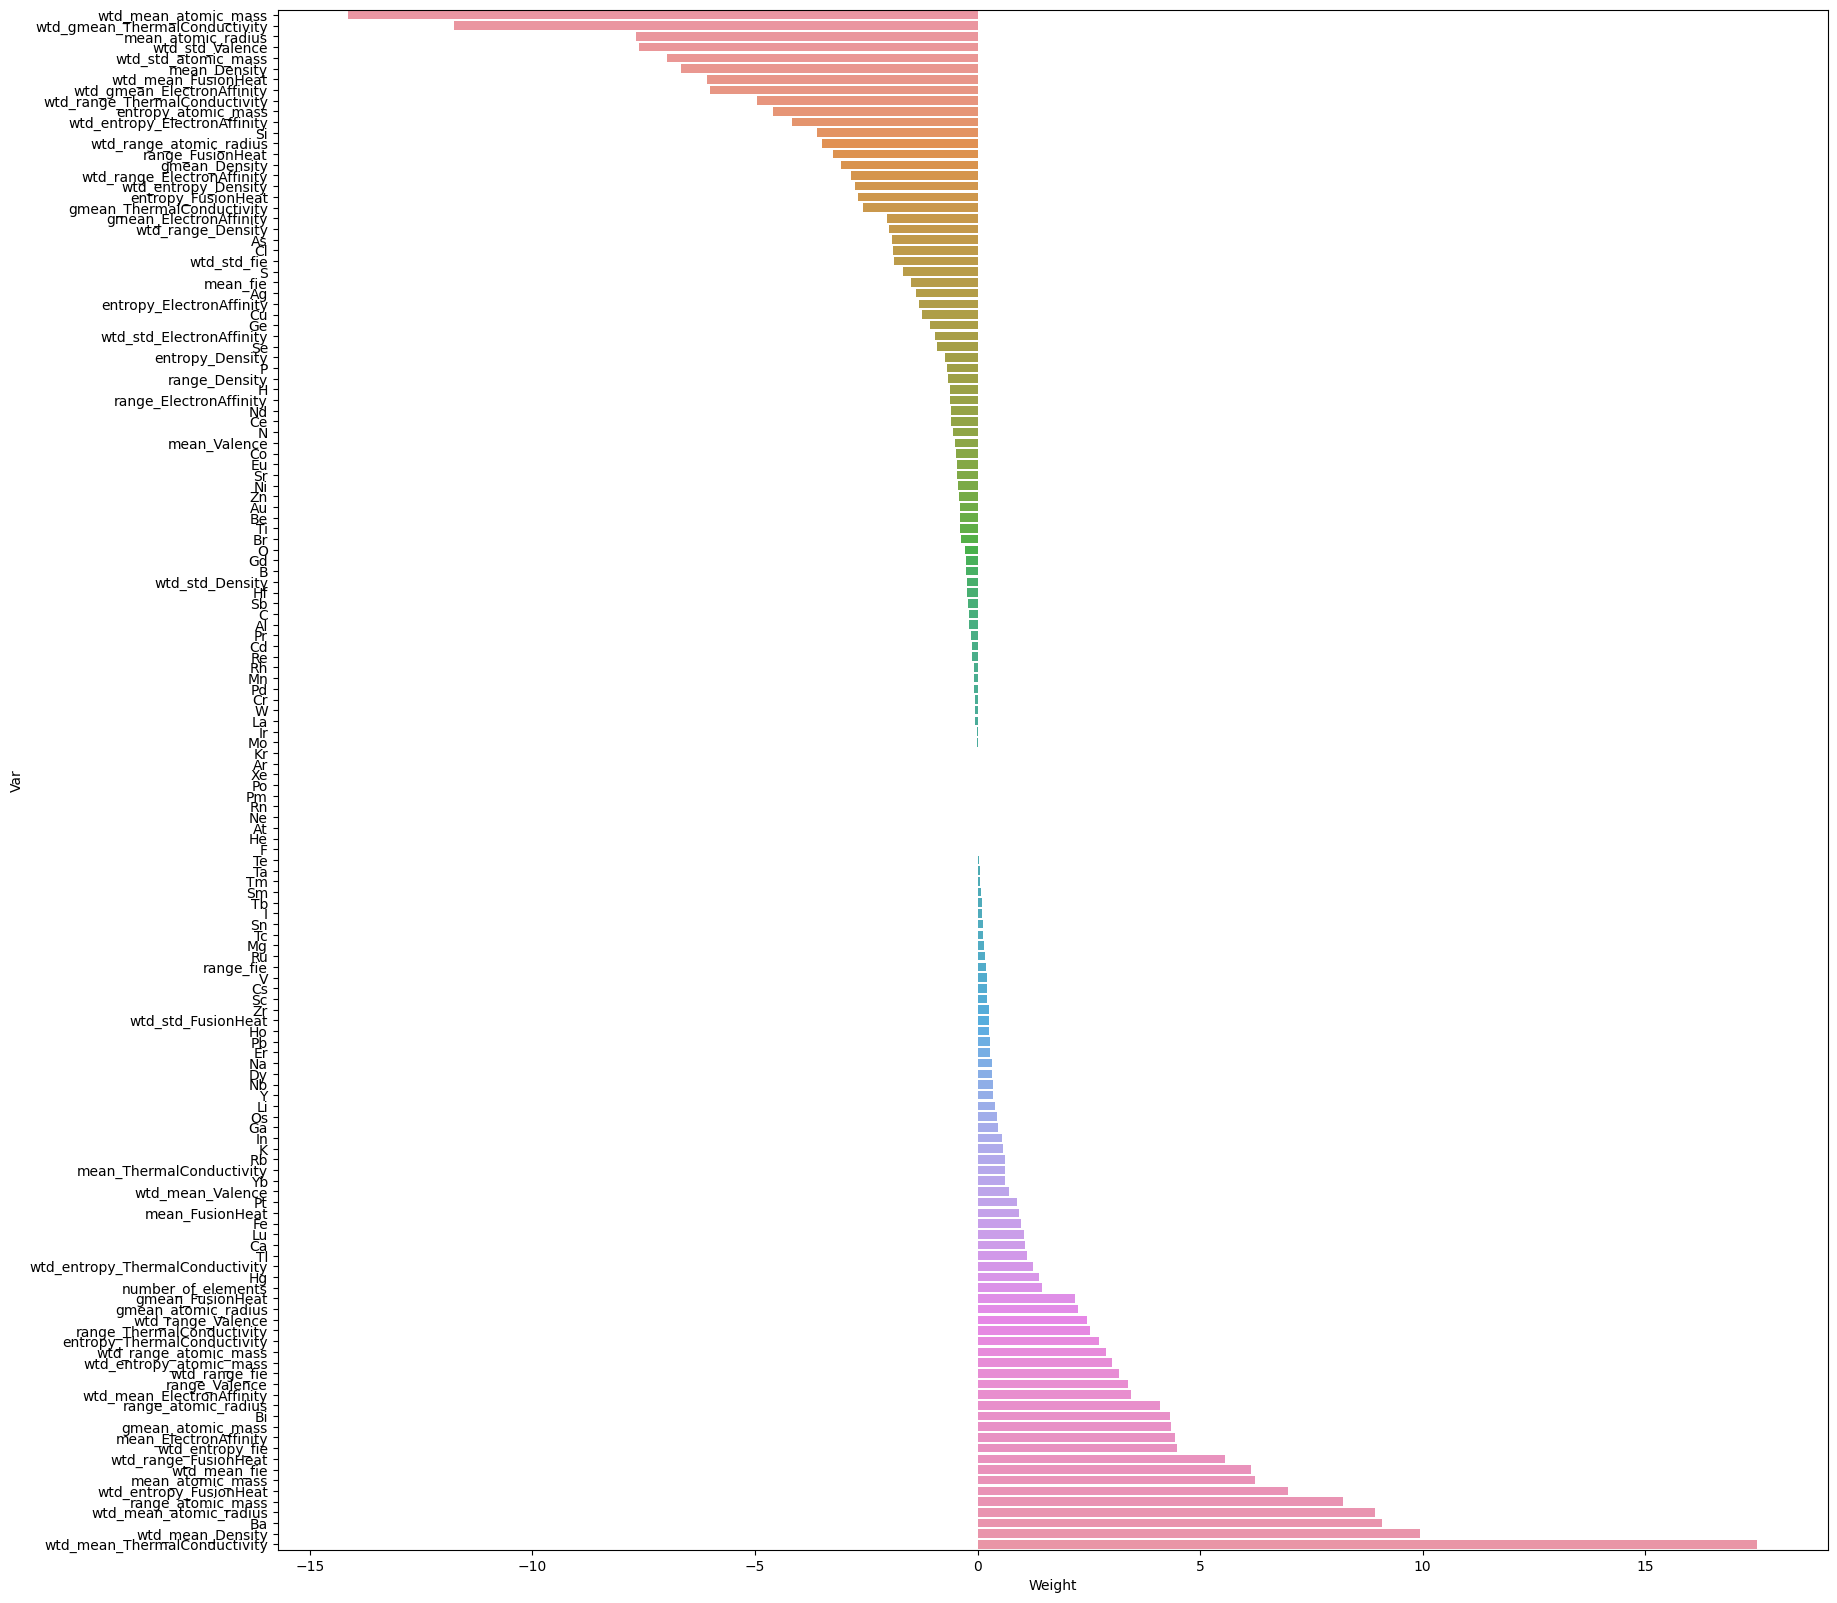

In [ ]:
Weights = pd.Series(regr.coef_, index = regr.feature_names_in_)
Weights = pd.DataFrame({'Var':Weights.index, 'Weight':Weights.values})
Weights = Weights.sort_values('Weight')
plt.figure(figsize=(20, 20))
sns.barplot(x='Weight', y = 'Var', data = Weights);

In [ ]:
Weights

,Var,Weight
47,range_ElectronAffinity,-16.268919
76,wtd_entropy_Valence,-15.099847
2,wtd_mean_atomic_mass,-14.965215
44,wtd_gmean_ElectronAffinity,-11.970381
29,std_atomic_radius,-11.678959
...,...,...
22,wtd_mean_atomic_radius,11.543423
17,range_fie,11.854126
16,wtd_entropy_fie,12.211110
62,wtd_mean_ThermalConductivity,18.796715


There were a number of variables included with a coefficient of 0.

In [ ]:
#0 weight variables
Weights_drop = Weights[Weights["Weight"] == 0] 
Weights_drop

,Var,Weight
134,Xe,0.0
98,Ar,0.0
141,Pm,0.0
90,Ne,0.0
164,Po,0.0
116,Kr,0.0
166,Rn,0.0
82,He,0.0
165,At,0.0
